# **Libraries**



In [220]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.data import AUTOTUNE 
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report
import pandas as pd

# **Preparing Dataset**
1. we can directly upload dataset in google colab disk (dhould be zip)
2. we can upload dataset to our google drive and connect to google drive 

In [221]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **unzip the dataset**

In [ ]:
!unzip "/content/drive/MyDrive/dataset/animal_photo.zip"

In [222]:
DATA_PATH = "./animal_photo"
train_dir = os.path.join(DATA_PATH,'train')
val_dir = os.path.join(DATA_PATH,'val')
test_dir = os.path.join(DATA_PATH,'test')

In [223]:
# testing dataset
print("train, validation and test list: ")
os.listdir(train_dir)
os.listdir(val_dir)
os.listdir(test_dir)

train, validation and test list: 


['lion', 'monkey', 'snake']

# **Hyperparameters**
### All images of dataset have the same size (256)

In [224]:
IMAGE_SIZE = (224,224)
CROP_SIZE = 112
RESIZE_TO = (128, 128)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
AUTOTUNE = AUTOTUNE

## **Preparing our train and validation and test data for training**

In [225]:
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                      shuffle=True,
                                                      label_mode='categorical',
                                                      batch_size=BATCH_SIZE,
                                                      image_size=IMAGE_SIZE)
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                      label_mode='categorical',
                                                      batch_size=BATCH_SIZE,
                                                      image_size=IMAGE_SIZE)
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                      label_mode='categorical',
                                                      batch_size=BATCH_SIZE,
                                                      image_size=IMAGE_SIZE)

Found 2295 files belonging to 3 classes.
Found 398 files belonging to 3 classes.
Found 1106 files belonging to 3 classes.


## **Check some images:**

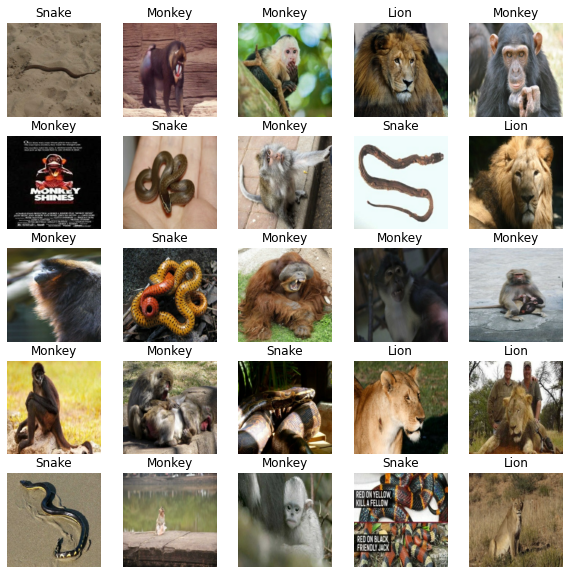

In [145]:
class_names = ["Lion" ,"Monkey","Snake"]

visualise_data = train_ds.take(1)
plt.figure(figsize=(10, 10))
for image, label in visualise_data:
    for i in range(25):
      ax = plt.subplot(5, 5, i + 1)
      img = image[i]/255.
      plt.imshow(img)
      plt.title(class_names[label[i].numpy().argmax()])
      plt.axis("off")

### **Speed Performance**

In [168]:
train_ds = train_ds.repeat(2).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

# **Data Augmentation**

In [61]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.CenterCrop(224,224),
    tf.keras.layers.RandomCrop(224,224),
    tf.keras.layers.RandomContrast(0.5)
])

# **Instantiate the VGG16 model**

In [62]:
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))


### **Freezing model**

In [63]:
# freezeing vgg16 model
conv_base.trainable = False

In [64]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [65]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [66]:
INPUT = keras.layers.Input(shape=(224, 224, 3))
x = keras.applications.vgg16.preprocess_input(INPUT)
x = data_augmentation(x)
x = conv_base(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
OUTPUT = keras.layers.Dense(3)(x)

model = keras.Model(inputs=[INPUT], outputs=[OUTPUT])

In [67]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0   

# **Compile Model**

In [68]:
optimizer = tf.keras.optimizers.RMSprop(lr=2e-5)
model.compile(optimizer=optimizer,
             loss=keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [69]:
EarlyStopping_callbacks = [ tf.keras.callbacks.EarlyStopping(patience=3) ]

In [70]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0   

In [71]:
history = model.fit(train_ds,
                   validation_data=val_ds,
                   epochs=10)

Epoch 1/10
72/72 [==============================] - 49s 460ms/step - loss: 0.3246 - accuracy: 0.9133 - val_loss: 0.1596 - val_accuracy: 0.9447
Epoch 2/10
72/72 [==============================] - 28s 382ms/step - loss: 0.0209 - accuracy: 0.9946 - val_loss: 0.1206 - val_accuracy: 0.9648
Epoch 3/10
72/72 [==============================] - 28s 384ms/step - loss: 0.0065 - accuracy: 0.9974 - val_loss: 0.1290 - val_accuracy: 0.9648
Epoch 4/10
72/72 [==============================] - 28s 385ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.1923 - val_accuracy: 0.9623
Epoch 5/10
72/72 [==============================] - 29s 389ms/step - loss: 0.0028 - accuracy: 0.9989 - val_loss: 0.1821 - val_accuracy: 0.9623
Epoch 6/10
72/72 [==============================] - 29s 389ms/step - loss: 0.0098 - accuracy: 0.9987 - val_loss: 0.2307 - val_accuracy: 0.9598
Epoch 7/10
72/72 [==============================] - 29s 392ms/step - loss: 6.2983e-05 - accuracy: 1.0000 - val_loss: 0.1830 - val_accuracy: 0.

# **Analysis model after trainning**

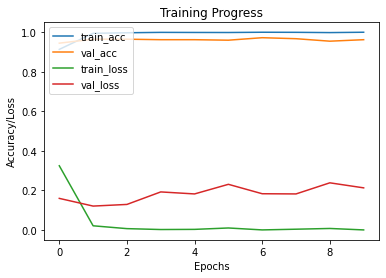

In [242]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

In [77]:
accuracy = model.evaluate(test_ds)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

18/18 [==============================] - 8s 405ms/step - loss: 0.1394 - accuracy: 0.9765
Accuracy: 97.65%


# **Saving and downloading model from google colab**

In [78]:
# Save the model
model.save('saved_model',save_format='tf')

INFO:tensorflow:Assets written to: saved_model/assets


In [84]:
# Download the model
!zip -r /content/saved_model.zip /content/saved_model
from google.colab import files
files.download("/content/saved_model.zip")

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/keras_metadata.pb (deflated 95%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved_model/variables/variables.index (deflated 67%)
  adding: content/saved_model/saved_model.pb (deflated 90%)
  adding: content/saved_model/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Prepare Labels and Prediction for `confusion_matrix`**

In [233]:
def get_labels_and_predictions(test_dataset) :
    labels = []
    preds  = []
    for item in test_dataset.take(-1) :
      image_batch = item[0]
      label_batch = item[1]
      y_pred= model.predict(image_batch)
      for y in np.array(y_pred) :
          preds.append(y.argmax())

      for lbl in np.array(label_batch) :
          labels.append(lbl.argmax())

    return np.array(labels) ,np.array(preds)

Labels  ,Predictios = get_labels_and_predictions(test_ds)

# **Confusion Matrix Function**

In [234]:
# Source code credit for this function: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Labels')
    plt.xlabel('Predictios')

In [235]:
confusion_matrix = confusion_matrix(Labels, Predictios)
accuracy_test = accuracy_score(Labels, Predictios)

# **Showing Information of `confusion_matrix`:**

In [241]:
print('/// Confusion Matrix:')
print('---------------------')
print(confusion_matrix, end='\n\n')

for class_ in range(len(class_names)):
  precision, recall = get_precision_recall(conf_mat, class_)
  print("Class {} ({}):".format(class_, class_names[class_]))
  print('\tPrecision: {:.2f}'.format(precision))
  print('\tRecall: {:.2f}'.format(recall), end='\n\n')

/// Confusion Matrix:
---------------------
[[214  16   0]
 [  3 475   5]
 [  0   2 391]]

Class 0 (Lion):
	Precision: 0.99
	Recall: 0.93

Class 1 (Monkey):
	Precision: 0.96
	Recall: 0.98

Class 2 (Snake):
	Precision: 0.99
	Recall: 0.99



In [238]:
def get_precision(conf ,class_):
  return conf[class_, class_] / confusion_matrix.sum(axis=0)[class_]
def get_recall(conf ,class_):
  return conf[class_, class_] / confusion_matrix.sum(axis=1)[class_]

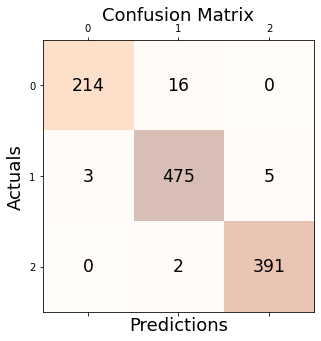

In [240]:
def plot_confusion_matrix():
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(confusion_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_mat[i, j], va='center', ha='center', size='xx-large')
 
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

plot_confusion_matrix()